### 1D Burger Equation NFTM Simulator using a CNN as the controller.

The Burger equation in 1-dimension is given by:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$


* We want to build a NFTM with a CNN-based update rule for simulating the 1D Burgers equation.

* NFTM architecture:
    * Neural Controller $C$ $\to$ CNN in this case.

    * Continuous memory field (spatial domain) $f_t$: **updates are restricted to neighbour points**.

    * Movable read/write heads that perform **local updates** $h_t$: operate over local regions/patches of this field.

* NFTM architecture for PDEs:
    * The continuous **field** models the spatial domain, a grid representing the solutions $u(x,t)$.

    * The **controller** reads a local patch (neighbourhood) at each time step, computes an update (using CNN), and writes the new value back (updates values in the field). Responsible of updating values + controlling position of read/write heads.

    * At each time step $t$ the CNN controller reads a region, for example: $[u_{i-1}, u_i, u_{i+1}]$ (in 1D) as its input.

    * The CNN uses this input to compute updates by applying a CNN kernel and then writes the updated values back to the same region.

#### Import necessary packages 

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
import os
import math
from torch.utils.data import Dataset, DataLoader

#### Load Training Data

* The following class builds training samples for training the NFTM.

* It extracts a spatial patch (neighbouring positions) at a fixed time $t$.

* The target value is the value at the center of the patch at the next time step $(t+1)$.

* INPUT: patch along the space at time $t$: $(u_{i-k, t},...,u_{i, t},...,u_{i+k, t})$ for a specific patch size $2k +1$.

* VISCOSITY $\nu$: a scalar.

* TARGET: $u_{i, t+1}$ (center's value in the next time step).

#### Extract local regions from field: create patches

* For each spatial position $i$, we want to extract the slide $[u_{i-r},...,u_i,...,u_{i+r}]$.

* $r$ is the patch radius (how many neighbours you consider from left and right side).

* We then pass this patch/region to the CNN controller to perform updates.

* Patch size: $2r +1$ (no. of points you take from spatial field).

* We create a 3D tensor `patches` storing the patch (neighbour points) for each spatial location in the field.

* Each `training sample` (patch): (input_patch, viscosity, target_value), where input_patch = neighbour points.

* `Batch size`: number of patches (training samples) running in parallel during each forward and backward pass of the NN.

### Training Data

* Input: `batch of input data patches` (shape = (batch_size, patch_size)) and a `batch of viscosities` (shape = (batch_size, 1)).

* Output: `batch of target values` at the input data patch center (shape = (batch_size, 1)).

In [11]:
class BurgersViscosityDataset(Dataset):
    def __init__(self, datasets, viscosities, patch_radius=1, pad_mode='replicate'):
        # datasets: list of tensors, each of shape (1, T, N)
        # viscosities: list of float scalars (one for each dataset)
        self.patches = []     # (num_samples, 2r+1)
        self.nu_vals = []     # (num_samples, 1)
        self.targets = []     # (num_samples, 1)
        patch_size = 2 * patch_radius + 1

        for data, nu in zip(datasets, viscosities):
            data = data.squeeze(0)  # (T, N): drop batch dim if present
            T, N = data.shape
            for t in range(T - 1):  # Last time step has no gt for (t+1)
                field = data[t]         # (N,)
                padded_field = torch.nn.functional.pad(field.unsqueeze(0), (patch_radius, patch_radius), mode=pad_mode).squeeze(0)  # (N + 2r,)
                # Extract all patches for this time step (N positions, including boundaries via padding):
                patches_t = padded_field.unfold(0, patch_size, 1)  # (N, patch_size)
                targets_t = data[t+1]  # (N,) next field
                # Viscosity: broadcast to all positions (N, 1)
                nu_col = torch.full((N, 1), float(nu), dtype=torch.float32)
                # Store
                self.patches.append(patches_t)
                self.nu_vals.append(nu_col)
                self.targets.append(targets_t.unsqueeze(1))
        # Concatenate all
        self.patches = torch.cat(self.patches, dim=0)   # (total_samples, patch_size)
        self.nu_vals = torch.cat(self.nu_vals, dim=0)   # (total_samples, 1)
        self.targets = torch.cat(self.targets, dim=0)   # (total_samples, 1)

    def __len__(self):
        return self.patches.shape[0]

    def __getitem__(self, idx):
        # Returns: spatial patch (patch_size,), viscosity (1,), target (1,)
        return self.patches[idx], self.nu_vals[idx], self.targets[idx]


In [ ]:
current_dir = Path(os.getcwd()) # get current directory

# Files with datasets for 1D burger eq for different values of viscosity:
files_burger = {
    0.001: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.001.npz",
    0.01: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.01.npz",
    0.1: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.1.npz",
    0.5: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.5.npz"
}

datasets = [] # list to store tensors corresponding to each dataset: each tensor has shape (1, T, N)
viscosities = [] # list to store the different values of viscosity.

# Load and process all datasets:
for viscosity, path in files_burger.items():
    uu_tensor = np.load(str(path.resolve()))['u'] # shape (T, N)
    data_tensor = torch.tensor(uu_tensor, dtype=torch.float32).unsqueeze(0) # (1, T, N)
    datasets.append(data_tensor)
    viscosities.append(viscosity)


# Create combined dataset for training the NFTM:
patch_dataset = BurgersViscosityDataset(datasets, viscosities, patch_radius=1)


# The data set will consist of triples (patch, viscosity, target), starting at t = 0 (all positions), then t=1 (all positions),...
# indices 0,...,N-1 correspond to u(x_0,0), u(x_1, 0),...,u(x_{N-1}, 0)
# we will have 1024(N)*201(T) elements for each viscosity value.
# to get solutions u(x,t) for next viscosity value: 
patch, nu, target = patch_dataset[0] # corresponding to position x_0, t = 0 and nu = 0.001
# patch, nu, target = patch_dataset[205825] 
print("Patch:", patch)
print("Viscosity:", nu)
print("Target (next value):", target)


Patch: tensor([0.0031, 0.0031, 0.0092])
Viscosity: tensor([0.0010])
Target (next value): tensor([0.0030])


#### Continuous field as a spatial grid

* This field acts as the memory of the NFTM, storing the solution values at each spatial point.

* Make use of tensors to represent the spatial field.

* Create a 1D tensor of size N (no. of spatial points per time snapshot): will store the values of the solution $u$ at each spatial point for a specific time snapshot.

* Each 1D tensor (vector) represents the spatial field $u(x,t)$ at a given time $t$: $[x_0,..., x_{N-1}]$, where $N=$ no. of spatial values per snapshot.

* $f_t = [u(x_0, t), ..., u(x_{N-1},t)]$.

* To compute the field at the next time step $t+\Delta t$, we use the vector from the previous time step $t$ as input.

* Each dataset corresponding to a specific viscosity contains all solution trajectories (full temporal evolutions) for that viscosity, and thus has its own set of initial fields (initial conditions $u(x,t=0)$) associated with that viscosity.

* SAME INITIAL CONDITION FOR ALL DATASETS. VALUES OF $u(x, t= 0)$ are equal, regardless of the value of $\nu$.

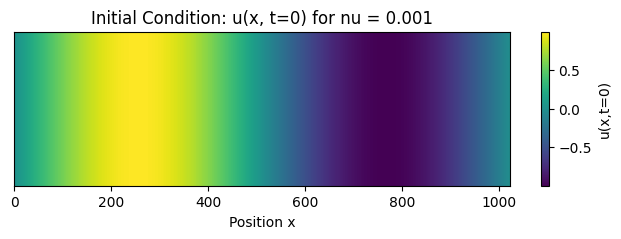

In [22]:
initial_field = datasets[0][0,0,:]  # initial field for t = 0  and nu = 0.001
# VISUALIZATION OF THE FIELD:
field_np = initial_field.numpy()

plt.figure(figsize=(8, 2))
plt.imshow(field_np[np.newaxis, :], aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='u(x,t=0)')
plt.xlabel('Position x')
plt.title(f'Initial Condition: u(x, t=0) for nu = 0.001')
plt.yticks([])
plt.show()


#### CNN controller

* Construct CNN that acts as the controller to process each patch.

* Typical architecture: input layer of patch size, one or two convolutional layers with kernel sizes equal or smaller than the patch size, nonlinear activations (ReLU or tanh), and output layer producing updated values for the center point in the patch.

* The CNN processes patches independently across the field.


In [53]:
# CNN controller definition:
class CNNController(nn.Module):
    # def __init__(self, patch_size):
    #     super().__init__()
    #     self.patch_size = patch_size
    #     # Two input channels: field patch and viscosity
    #     self.conv1 = nn.Conv1d(in_channels=2, out_channels=8, kernel_size=patch_size, padding=0)
    #     self.activation1 = nn.Tanh()
    #     self.fc = nn.Sequential(
    #         nn.Linear(8, 32),  # For output after global pooling
    #         nn.Tanh(),
    #         nn.Linear(32, 1)
    #     )
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size
        # Two input channels: field patch and viscosity
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=patch_size, padding=0)
        self.activation1 = nn.ReLU()
        self.pool1 = nn.AdaptiveMaxPool1d(1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=1)
        self.activation2 = nn.ReLU()
        self.final_fc = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(32, 1)
        )

    def forward(self, patch, nu):
        # patch: (batch_size, patch_size)
        # nu: (batch_size, 1)
        nu_channel = nu.repeat(1, self.patch_size)
        x = torch.stack([patch, nu_channel], dim=1)  # (batch_size, 2, patch_size)
        x = self.conv1(x)  # (batch_size, 16, out_len1)
        x = self.activation1(x)
        x = self.pool1(x)  # (batch_size, 16, ...)
        x = self.conv2(x)  # (batch_size, 32, ...)
        x = self.activation2(x)
        x = x.view(x.shape[0], -1)
        x = self.final_fc(x)  # (batch_size, 1)
        return x
        
    # def forward(self, patch, nu): # input data patch and viscosity patch
    #     # patch: (batch_size, patch_size)
    #     # nu: (batch_size, 1), scalar viscosity per sample
    #     # Expand viscosity to match patch length as second channel
    #     nu_channel = nu.repeat(1, self.patch_size)
    #     x = torch.stack([patch, nu_channel], dim=1)  # (batch_size, 2, patch_size)
    #     x = self.conv1(x)  # (batch_size, 8, 1)
    #     x = self.activation1(x)
    #     x = x.squeeze(-1)  # (batch_size, 8)
    #     x = self.fc(x)     # (batch_size, 1)
    #     return x
    

    
# Create CNN controller for our NFTM:
cnn_controller = CNNController(patch_size = 3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_controller.to(device)

CNNController(
  (conv1): Conv1d(2, 16, kernel_size=(3,), stride=(1,))
  (activation1): ReLU()
  (pool1): AdaptiveMaxPool1d(output_size=1)
  (conv2): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
  (activation2): ReLU()
  (final_fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32, out_features=1, bias=True)
  )
)

#### Read/Write head

* The controller reads patches, computes local updates, and writes these updates back into the corresponding local regions of the field.

* Reading: extract patches (local neighbourhoods) centered at each spatial position. These patches have shape `(batch_size, N, patch_size)`.

* Need to **reshape** patches to `(batch_size * N, 1, patch_size)`, to go as **input** into the CNN controller. This enables the CNN to process all patches in parallel as separate inputs in a batch.

* We treat each patch (local neighbours) as a separate 1D sample with 1 channel + length equal to patch_size.

* CNN **outputs** a **scalar value** per patch, with shape: `(batch_size * N, 1, 1)`.

* Need to **reshape** back to the field shape: `(batch_size,  N)`.

* Writing: updating the field.


#### Loss Function

* A common choice for the cost function is the MSE: $$L_{MNE} = \frac{1}{N} \sum_{i = 1}^{N} \sum_{t = 1}^{T} (u_{i,t} - \hat u_{i,t})^2$$

* N = no. spatial points at each time snapshot.

* T = no. of time snapshots where solution is considered.

* $\hat u_{i,t}$ = NFTM's predicted velocity at spatial point $i$ and time $t$.

* $u_{i,t}$ = truth velocity at spatial point $i$ and time $t$.

* The error between predicted values and truth solutions from your training data at different time steps.

In [54]:
mse_loss = nn.MSELoss() # LOSS FUNCTION

#### Optimizer

* We backpropagate the loss and update the CNN controller's weights using an optimizer.

    * Clear the gradients before backpropagation: `optimizer.zero_grad()`.

    * Compute gradients of the loss with respect to model parameters (backpropagation): `loss.backward()`.

    * Update the model parameters using the computed gradients: `optimizer.step()`.

* We can use the Adam optimizer among others.

In [55]:
optimizer = torch.optim.Adam(cnn_controller.parameters(), lr=1e-3) # OPTIMIZER

#### Training Loop

In [56]:
num_epochs = 10  # adjust as needed
batch_size = 64
epoch_losses = []  # list to store average loss per epoch
fields_history = []  # Optionally store predictions for heatmap

for epoch in range(num_epochs):
    running_loss = 0.0
    cnn_controller.train()
    for patch, nu, target in DataLoader(patch_dataset, batch_size=batch_size, shuffle=True):
        patch, nu, target = patch.to(device), nu.to(device), target.to(device)
        optimizer.zero_grad()
        preds = cnn_controller(patch, nu)  # (batch_size, 1)
        loss = mse_loss(preds, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * patch.size(0)
    epoch_loss = running_loss / len(patch_dataset)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}: Loss={epoch_loss:.6f}")
    if epoch in [0, num_epochs//2, num_epochs-1]:
        # Record example predictions for heatmap at selected milestones
        cnn_controller.eval()
        with torch.no_grad():
            sample_patch, sample_nu, sample_target = patch_dataset[0:1024]  # Example: first full field at t=0
            sample_pred = cnn_controller(sample_patch.to(device), sample_nu.to(device)).cpu().numpy().squeeze()
            fields_history.append(sample_pred)

Epoch 1/10: Loss=0.000596
Epoch 2/10: Loss=0.000021
Epoch 3/10: Loss=0.000020
Epoch 4/10: Loss=0.000018
Epoch 5/10: Loss=0.000016
Epoch 6/10: Loss=0.000015
Epoch 7/10: Loss=0.000013
Epoch 8/10: Loss=0.000012
Epoch 9/10: Loss=0.000010
Epoch 10/10: Loss=0.000010


In [60]:
# Define rollout parameters
viscosity_index = viscosities.index(0.01)
ground_truth = datasets[viscosity_index][0].cpu().numpy()  # (T, N)
initial_field = datasets[viscosity_index][0, 0]           # torch tensor, shape (N,)
viscosity_value = viscosities[viscosity_index] 
T, N = ground_truth.shape
pad_amt = (3 - 1) // 2
field = initial_field.clone().to(device)  # shape (N,)
pred_trajectory = torch.zeros((T, N), device=device)
pred_trajectory[0] = field

cnn_controller.eval()
with torch.no_grad():
    for t in range(1, T):
        # Create spatial patches for entire field
        field_padded = torch.nn.functional.pad(field, (pad_amt, pad_amt), mode='reflect')
        patches = field_padded.unfold(0, 3, 1)  # shape (N, patch_size)
        nu_batch = torch.full((N, 1), viscosity_value, device=device)
        field = cnn_controller(patches, nu_batch).squeeze(-1)  # shape (N,)
        pred_trajectory[t] = field
fields_pred = pred_trajectory.cpu().numpy()


NotImplementedError: Only 2D, 3D, 4D, 5D padding with non-constant padding are supported for now

### Loss Evolution Plot

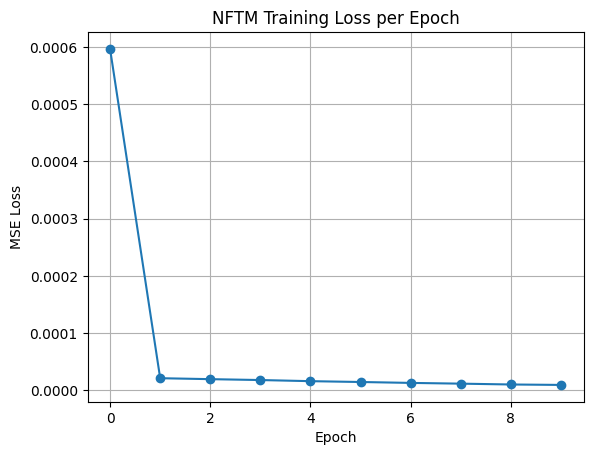

In [57]:
plt.figure()
plt.plot(epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('NFTM Training Loss per Epoch')
plt.grid(True)
plt.show()

### Heatmap illustrating the evolution of the NFTM training

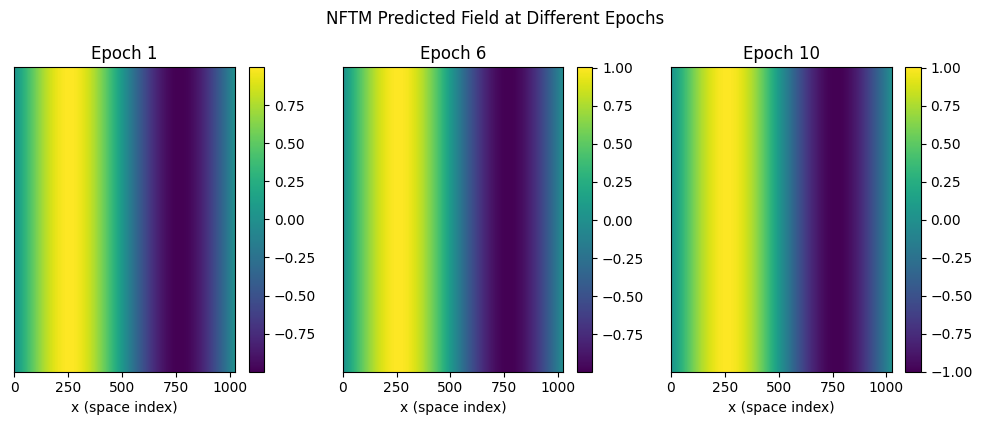

In [58]:
plt.figure(figsize=(10,4))
for i, field in enumerate(fields_history):
    plt.subplot(1, len(fields_history), i+1)
    plt.imshow(field[np.newaxis, :], aspect='auto', cmap='viridis', interpolation='nearest')
    plt.title(f'Epoch { [0, num_epochs//2, num_epochs-1][i] + 1 }')
    plt.xlabel('x (space index)')
    plt.colorbar()
    plt.yticks([])
plt.tight_layout()
plt.suptitle('NFTM Predicted Field at Different Epochs', y=1.05)
plt.show()


### Error heatmap

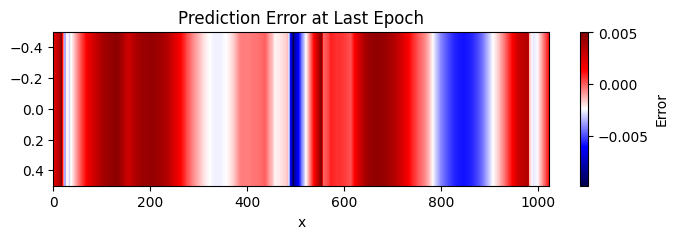

In [59]:
true_field = datasets[0][0,1,:].numpy()  # "target" at t=1 (choose matching time/viscosity)
pred_field = fields_history[-1]  # Output from final epoch
err_field = pred_field - true_field
plt.figure(figsize=(8,2))
plt.imshow(err_field[np.newaxis, :], aspect='auto', cmap='seismic', interpolation='nearest')
plt.title('Prediction Error at Last Epoch')
plt.xlabel('x')
plt.colorbar(label='Error')
plt.show()


In [212]:
def visualize_heatmap(field_pred, field_true, sample_idx=0):
    print(f"Visualizing solutions for viscosity = {nu[sample_idx].item():.4f}")

    pred = field_pred[sample_idx].cpu().detach().numpy()  # shape (T, N)
    true = field_true[sample_idx].cpu().detach().numpy()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(true, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='u(x,t) Ground Truth')
    plt.xlabel('Spatial position x')
    plt.ylabel('Time step t')
    plt.title('True Trajectories')

    plt.subplot(1, 2, 2)
    plt.imshow(pred, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='u(x,t) Predicted')
    plt.xlabel('Spatial position x')
    plt.ylabel('Time step t')
    plt.title('Predicted Trajectories')

    plt.tight_layout()
    plt.show()



In [210]:
# num_epochs = 30  # or however many epochs you want for evaluation

# for epoch in range(num_epochs):
#     cnn_controller.eval()
#     with torch.no_grad():
#         for initial_field, full_trajectory, nu in dataloader:
#             batch_size, N = initial_field.shape
#             T = full_trajectory.shape[1]
#             device = initial_field.device

#             predictions = torch.zeros((batch_size, T, N), device=device)
#             predictions[:, 0, :] = initial_field

#             field = initial_field

#             for t in range(1, T):
#                 padded_field = torch.nn.functional.pad(field, (r, r), mode='replicate')
#                 patches = padded_field.unfold(1, patch_size, 1)
#                 patches_reshaped = patches.reshape(batch_size * N, 1, patch_size)
#                 outputs = cnn_controller(patches_reshaped).reshape(batch_size, N)
#                 field = outputs
#                 predictions[:, t, :] = field

#             targets_batch = torch.zeros_like(predictions)
#             for i in range(batch_size):
#                 viscosity_value = round(nu[i].item(), 3)
#                 target_trajectory = targets[viscosity_value].squeeze(0).to(device)  # (T, N)
#                 targets_batch[i] = target_trajectory

#             print(f"Epoch {epoch+1}/{num_epochs}")
#             visualize_heatmap(predictions, targets_batch, sample_idx=0)
#             break  # visualize only first batch per epoch

#     cnn_controller.train()


Visualizing solutions for viscosity = 0.0100


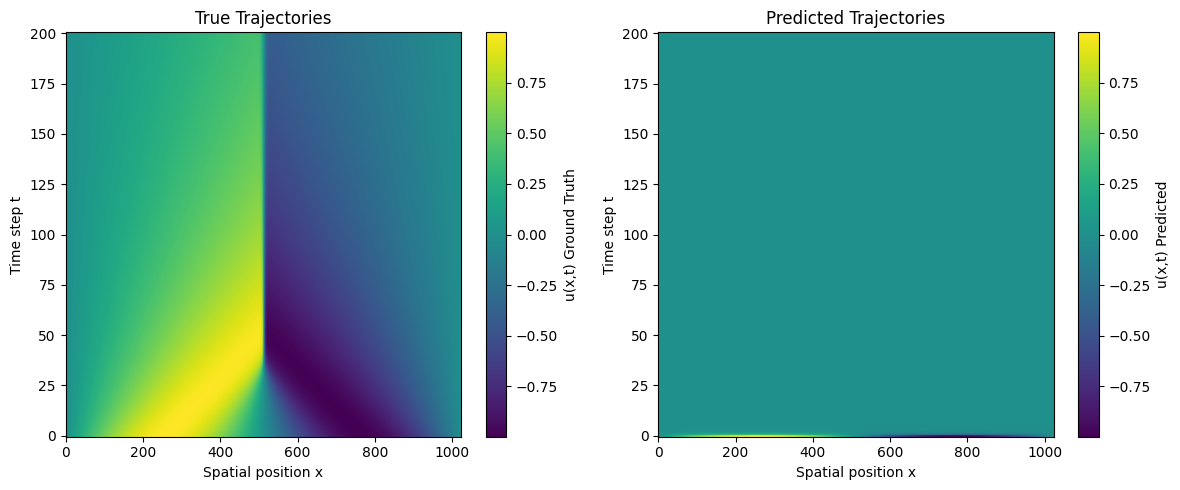

CNNController(
  (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,))
  (activation1): Tanh()
  (conv2): Conv1d(8, 8, kernel_size=(1,), stride=(1,))
  (activation2): Tanh()
  (output_layer): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
)

In [213]:
# --- Final evaluation and visualization ---
cnn_controller.eval()
with torch.no_grad():
    for initial_field, full_trajectory, nu in dataloader:
        batch_size, N = initial_field.shape
        T = full_trajectory.shape[1]
        device = initial_field.device

        predictions = torch.zeros((batch_size, T, N), device=device)
        predictions[:, 0, :] = initial_field

        field = initial_field
        for t in range(1, T):
            padded_field = torch.nn.functional.pad(field, (r, r), mode='replicate')
            patches = padded_field.unfold(1, patch_size, 1)
            patches_reshaped = patches.reshape(batch_size * N, 1, patch_size)
            outputs = cnn_controller(patches_reshaped).reshape(batch_size, N)
            field = outputs
            predictions[:, t, :] = field

        targets_batch = torch.zeros_like(predictions)
        for i in range(batch_size):
            viscosity_value = round(nu[i].item(), 3)
            target_trajectory = targets[viscosity_value].squeeze(0).to(device)
            targets_batch[i] = target_trajectory

        visualize_heatmap(predictions, targets_batch, sample_idx=0)
        break  # visualize only the first batch

cnn_controller.train()


Summary of the Architecture:

* Input: 1D spatial field representing $u(x,t)$.

* Patch extraction: Sliding local neighborhoods of radius $r$.

* Controller: CNN processing each local patch.

* Update: Local field value updates returned by CNN.

* Iteration: Time-stepping loop applying CNN update repeatedly.

* Output: Predicted evolution of $u(x,t)$ over time.

This setup lets you build an end-to-end differentiable NFTM that learns local update rules via convolutional kernels, naturally capturing the physics of the 1D Burgers equation with your training data.